In [67]:
#import dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import glob 
import warnings
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np
cmaps = OrderedDict()
warnings.filterwarnings('ignore')



In [2]:
#merge csv files
glob_path = "raw_csv"
all_files = glob.glob(glob_path+"/*.csv")
glob_df = pd.concat((pd.read_csv(f) for f in all_files))




In [154]:
#export dataframe to csv
glob_df.to_csv("raw_csv/total_data.csv")

In [3]:
#reduce columns 
small_df = glob_df.loc[:,("CBBC Code", "Underlying",'Bull/Bear',"Trade Date", "No. of CBBC Bought *","No. of CBBC Sold *",
                         "No. of CBBC still out in market *",
                         "% of issue still out in market *",
                          "Call Level","Ent. Ratio^", "Maturity Date")]

#small_df.head()


In [4]:
#focus on the top the most popular CBBC which is HSI
hsi_700_df = small_df.loc[(small_df["Underlying"] == "HSI"), :]
#hsi_700_df

In [5]:

#round strikes to nearest 100 for grouping
hsi_700_df["Call Level"] = hsi_700_df["Call Level"].astype(float).round(-2)
#hsi_700_df

In [6]:
#Calculate No. of Shares 
hsi_700_df["Shares"]= hsi_700_df["No. of CBBC still out in market *"] / hsi_700_df["Ent. Ratio^"]
hsi_700_df.head()

,CBBC Code,Underlying,Bull/Bear,Trade Date,No. of CBBC Bought *,No. of CBBC Sold *,No. of CBBC still out in market *,% of issue still out in market *,Call Level,Ent. Ratio^,Maturity Date,Shares
0,57003,HSI,Bull,1/31/2019,380000.0,-80000.0,2290000.0,1.15,24100.0,12000.0,10/29/2020,190.833333
3,57016,HSI,Bull,1/31/2019,150000.0,0.0,100000.0,0.05,24600.0,10000.0,9/29/2020,10.000000
4,57017,HSI,Bull,1/31/2019,0.0,0.0,3290000.0,1.65,23500.0,10000.0,10/29/2020,329.000000
5,57019,HSI,Bull,1/31/2019,30000.0,0.0,0.0,0.00,23300.0,10000.0,9/29/2020,0.000000
6,57023,HSI,Bull,1/31/2019,80000.0,0.0,0.0,0.00,23100.0,10000.0,10/29/2020,0.000000


In [7]:

#Group By CBBC Cod,Bull/Bear, Call Level and Trade Date
group_df = hsi_700_df.groupby(["Underlying","Bull/Bear","Call Level","Trade Date"],as_index=False)[['Shares']].sum()

#group_df

In [8]:
#remove rows with zeros
group_df = group_df[group_df.Shares != 0]



In [9]:
#convert Trade Date String to DateTime
group_df["Trade Date"]= pd.to_datetime(group_df["Trade Date"]) 

In [10]:
#clean text in Bull/Bear column
group_df["Bull/Bear"]= group_df["Bull/Bear"].replace("Bear      ", "Bear").replace("Bull      ", "Bull")

In [11]:
#Sort Columns
group_df_sorted = group_df.sort_values(["Underlying","Bull/Bear","Call Level","Trade Date"])

In [12]:
group_df_sorted.dtypes

Underlying            object
Bull/Bear             object
Call Level           float64
Trade Date    datetime64[ns]
Shares               float64
dtype: object

In [13]:
#group_df_sorted.loc[group_df_sorted["Bull/Bear"]=="Bull",group_df_sorted["Shares"]]*-1
group_df_sorted.loc[ ( group_df_sorted["Bull/Bear"] == "Bull"), "Shares" ] *=-1
group_df_sorted.tail()


,Underlying,Bull/Bear,Call Level,Trade Date,Shares
29170,HSI,Bull,30000.0,2019-04-17,-1742.000000
29171,HSI,Bull,30000.0,2019-04-18,-1493.500000
29172,HSI,Bull,30000.0,2019-04-24,-143.666667
29180,HSI,Bull,30100.0,2019-04-15,-17880.000000
29182,HSI,Bull,30100.0,2019-04-17,-50.833333


In [79]:
#count share imbalance
imbal_df = group_df_sorted.groupby(["Trade Date"],as_index=False)[['Shares']].sum()
imbal_df.head()

,Trade Date,Shares
0,2018-10-02,-185315.769231
1,2018-10-03,-16421.923077
2,2018-10-04,-67568.307692
3,2018-10-05,31180.000000
4,2018-10-08,22672.397436


In [14]:
print(group_df_sorted["Shares"].max())
print(group_df_sorted["Shares"].min())

122988.83333333334
-142816.16666666666


In [15]:
#export to csv
group_df_sorted.to_csv('Clean_Oct2018_Sep2019.csv',index=False)

In [16]:
#import hsi closing and volume data 
hsi_close_df = pd.read_csv("raw_csv/hsi_close.csv")
hsi_close_df.keys()

Index(['Date', 'Close', 'Volume'], dtype='object')

In [17]:
#convert Trade Date String to DateTime
hsi_close_df["Date"]= pd.to_datetime(hsi_close_df["Date"]) 

In [18]:
#rename date column
hsi_close_df.rename(columns = {"Date":"Trade Date", "Volume":"HSI Volume"}, inplace=True)
hsi_close_df.head()
hsi_close_df.max()

Trade Date    2019-09-26 00:00:00
Close                     30157.5
HSI Volume             3518978800
dtype: object

In [19]:
#remove extra dates in df
# Get names of indexes for which column Age has value 30
indexNames = hsi_close_df[hsi_close_df['Trade Date'] > pd.Timestamp('20190912')].index

hsi_close_df.drop(indexNames , inplace=True)
hsi_close_df.tail()

,Trade Date,Close,HSI Volume
229,2019-09-06,26690.75977,1895344700
230,2019-09-09,26681.40039,1700948300
231,2019-09-10,26683.67969,1738020300
232,2019-09-11,27159.06055,2072246200
233,2019-09-12,27087.63086,1337046900


In [20]:
#merge hsi close data with CBBC data
group_df_final = pd.merge(group_df_sorted,hsi_close_df, on="Trade Date", how="inner")
group_df_final.head()
group_df_final["Trade Date"].max()

Timestamp('2019-09-12 00:00:00')

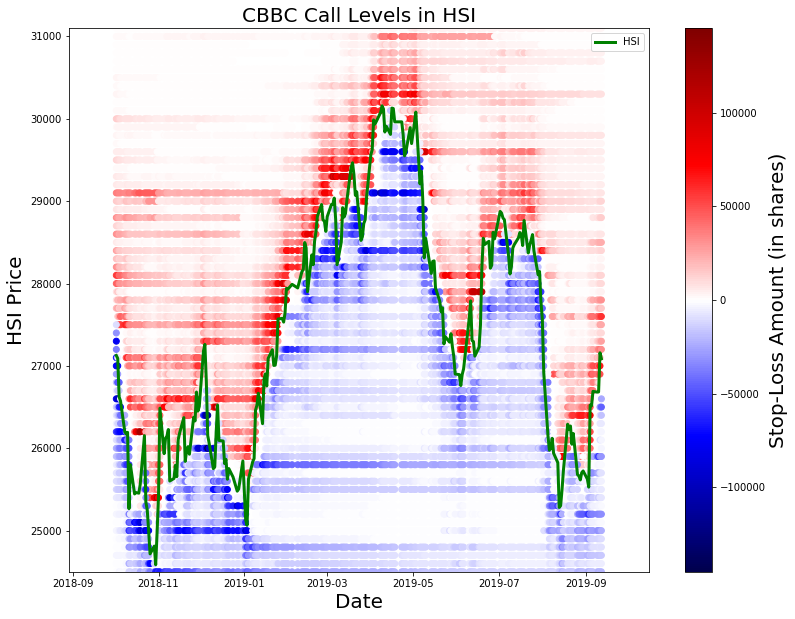

In [176]:
#Bull and Bear Call Level Heat-Map

#figure
fig, ax1 = plt.subplots()
fig.set_size_inches(13, 10)

#labels
ax1.set_xlabel('Date', fontsize=20)
ax1.set_ylabel('HSI Price', fontsize=20)
ax1.set_title('CBBC Call Levels in HSI', fontsize=20)
ax1.set_ylim(24500,31100)

#set colors and colormap scale
c = group_df_sorted['Shares']
normalize = mpl.colors.Normalize(vmin=-145000, vmax=145000)

#plot
plt.scatter(group_df_sorted["Trade Date"], group_df_sorted["Call Level"], c = c, cmap = "seismic", norm =normalize)
plt.plot(hsi_close_df["Trade Date"],hsi_close_df["Close"], c = "green", lw=3, label = "HSI")
plt.legend()
cbar = plt.colorbar()
cbar.set_label('Stop-Loss Amount (in shares)', fontsize =20)

plt.savefig("Charts/Heat_Map.png")

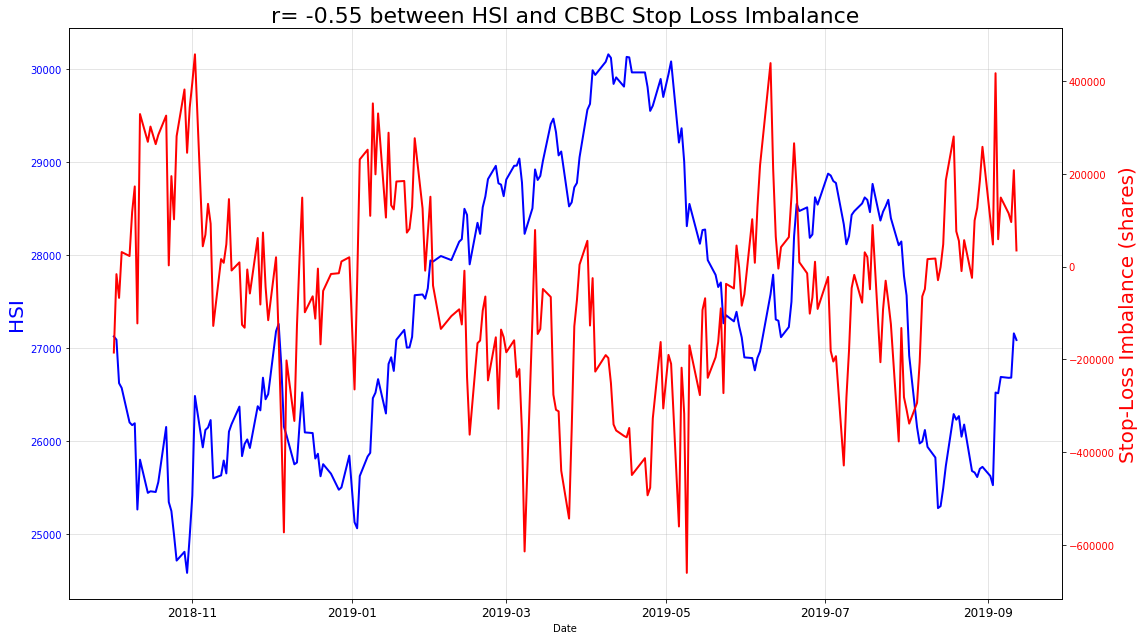

In [178]:
# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(16,9))
ax1.plot(hsi_close_df["Trade Date"],hsi_close_df["Close"], c = "blue", lw=2, label="HSI")

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(hsi_close_df["Trade Date"],imbal_df["Shares"], c = "red", lw=2, label="Stop-Loss Imbalance")

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Date')
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('HSI', color='blue', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='blue' )
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("Stop-Loss Imbalance (shares)", color='red', fontsize=20)
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_title("r= -0.55 between HSI and CBBC Stop Loss Imbalance", fontsize=22)
fig.tight_layout()


corr = np.corrcoef(hsi_close_df["Close"], imbal_df["Shares"])
correlation = (corr[0][1])
corr_round = round(correlation, 3)

plt.savefig("Charts/Corr.png")

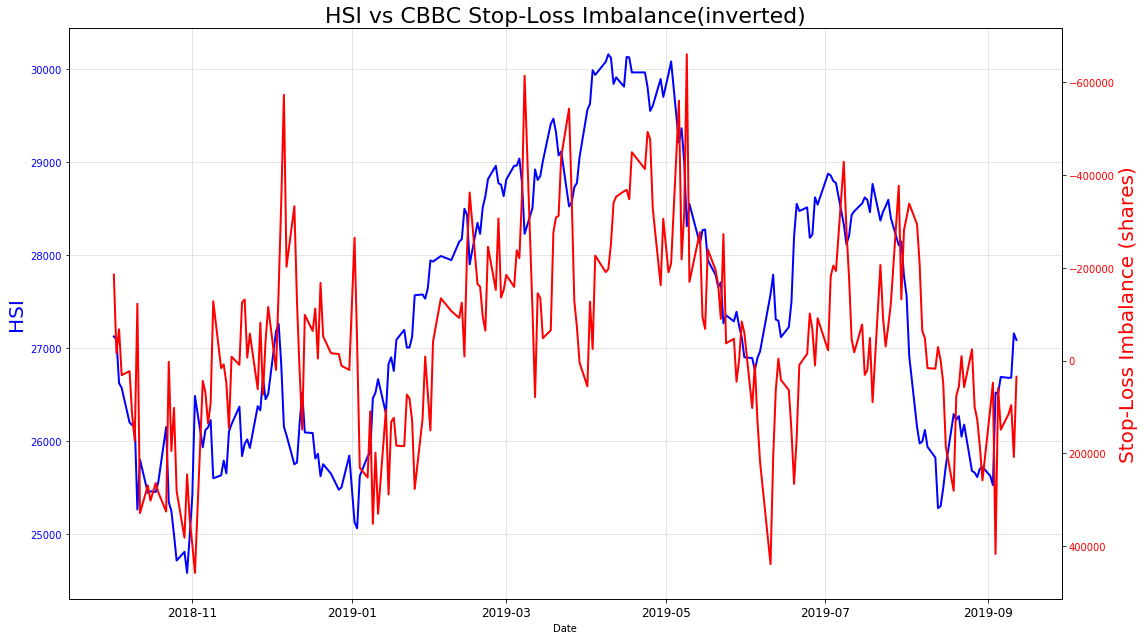

In [180]:
# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(16,9))
ax1.plot(hsi_close_df["Trade Date"],hsi_close_df["Close"], c = "blue", lw=2)

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(hsi_close_df["Trade Date"],imbal_df["Shares"], c = "red", lw=2)

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Date')
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('HSI', color='blue', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='blue' )
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2 = plt.gca()
ax2.invert_yaxis()
ax2.set_ylabel("Stop-Loss Imbalance (shares)", color='red', fontsize=20)
ax2.tick_params(axis='y', labelcolor='red')

ax2.set_title("HSI vs CBBC Stop-Loss Imbalance(inverted)", fontsize=22)
fig.tight_layout()


plt.savefig("Charts/Invert.png")